# Nature-based climate resilience through shoreline transformation
Andre de Souza de Lima $^1$; Tyler Miesse $^1$; Daniel Cardona $^1$; Celso Ferreira $^1$; Ali Shahabi $^2$; Navid Tahvildari $^2$ 

$^1$ Department of Civil, Environmental and Infrastructure Engineering, George Mason University, Fairfax, VA 

$^2$ Department of Civil and Environmental Engineering, Old Dominion University, Norfolk, VA 
--- ---

<center><img src="https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/biogenic-solutions_53109206880_o.jpg?raw=true" width = "825" height = "480" align = "center"/></center>

## Introduction

Global climate change has led to many adverse impacts including changing weather patterns and an increase in the severity and frequency of extreme weather events. Traditional hard engineering solutions for coastal protection, such as seawalls and bulkheads, are becoming inadequate as they do not have the capacity to keep pace with the accelerating impacts of climate change. In response, there is growing interest in Natural and Nature-Based Features (NNBF), which offer innovative and adaptive approaches to coastal protection. NNBFs, such as salt marshes or living shorelines, have demonstrated potential for mitigating wave energy, reducing flood risks, and enhancing coastal resilience. However, the effectiveness of these features can vary based on their physical attributes and the specific environmental conditions in which they are implemented. The inconsistent performance of NNBFs has posed challenges for their widespread adoption, partly due to uncertainties in their efficacy and barriers in public policy.

This research focuses on evaluating the performance of NNBFs in attenuating waves through innovative field-scale prototypes and the natural environment. Here we aim to deepen our understanding of how these interventions can contribute to enhancing coastal resilience.

In [15]:
import warnings;warnings.filterwarnings("ignore")
import pathlib as pl;            import numpy as np
import netCDF4 as nc4;           import pandas as pd
import matplotlib.pyplot as plt; import xarray as xr
import json;                     import requests
import plotly.graph_objs as go;  import folium
from folium.plugins import BeautifyIcon; import matplotlib as mpl
import geopandas as gpd; from matplotlib.lines import Line2D
from random import randint
from chart_studio import plotly
from plotly.offline import plot,iplot, init_notebook_mode
from shapely import Polygon,Point,LineString
from datetime import date, datetime, timedelta
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.lines as mlines
from matplotlib.dates import DateFormatter
from IPython.core.display import display, HTML
import io
from PIL import Image

In [ ]:
root = pl.Path('C:/Users/dcardon2/OneDrive - George Mason University - O365 Production/fall_24/Independent_Study/Seagrant_Prj/Data/Canal')

def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    if datenum < 1:
        temp = np.nan
    else:
        days = datenum % 1
        hours = days % 1 * 24
        minutes = hours % 1 * 60
        seconds = minutes % 1 * 60
        temp = datetime.fromordinal(int(datenum)) \
               + timedelta(days=int(days)) \
               + timedelta(hours=int(hours)) \
               + timedelta(minutes=int(minutes)) \
               + timedelta(seconds=round(seconds)) \
               - timedelta(days=366)
    return temp

date_standard = []
time_standard = []
for i in range(80):
    date_standard.append(datetime(2023, 7, 21, 0, 0) + timedelta(minutes = i))
for i in date_standard:
    time_standard.append(i.time())

fnames_bf = {'GMU05.nc':'Bank','GMU03.nc':'Bank', 'GMU06.nc':'Bank', 'GMU10.nc':'Bank', 'GMU07.nc':'Bank'}
fnames_af = {'GMU05.nc':'Bank', 'GMU03.nc':'Bank', 'GMU09.nc':'Bank','GMU11.nc':'Bank','GMU07.nc':'Bank'}
nnfb_groups = {'oyster_bf': ['GMU10.nc'], 'oyster_af': ['GMU09.nc', 'GMU11.nc'], 'geo_bf': ['GMU07.nc'], 'geo_af': ['GMU07.nc'], 'both_bf': ['GMU05.nc', 'GMU03.nc'], 'both_af': ['GMU05.nc', 'GMU03.nc']}

def get_data(fnames, root, file_type = 'before'):
    """
    Open the before files and return the data.
    :param fnames_bf: Dictionary of before files
    :param root:      Root directory
    :return:          Data of before files
    """
    data = []
    if file_type == 'before':
        for k, v in fnames.items():
            data.append({k : xr.open_dataset(root / 'Wave_data' / 'rbr_072123' / '02_Processed' / 'canal' / k)})
        return data
    else:
        for k, v in fnames_af.items():
            data.append({k : xr.open_dataset(root / 'Wave_data' / 'rbr_070924' / '02_Processed' / k)})
    return data
 
def plottable_data(data, *, file_type, x_axis = 'not shared'):
    """
    Get the data in a plottable format.
    :param data: Data from the files
    :return:     Time and Hs data in a plottable format
    """
    lines = []
    for k in range(len(data)):
        i = list(data[k].keys())[0]
        dt = []
        for t in range(len(data[k][i]['Time'].data)):
            dt.append(datenum_to_datetime(data[k][i]['Time'].data[t]))
        time = pd.to_datetime(dt)
        if x_axis == 'shared':
            hs = []
            for h in range(len(data[k][i]['Hs'].data)):
                if file_type == 'before':
                    if datetime(2023, 7, 21, 14, 45) <= time[h] <= datetime(2023, 7, 21, 16, 5):
                        hs.append(data[k][i]['Hs'].data[h])
                else:
                    if datetime(2024, 7, 9, 11, 31) <= time[h] <= datetime(2024, 7, 9, 12, 33):
                        hs.append(data[k][i]['Hs'].data[h])
            time = time_standard
        
        else:
            hs = data[k][i]['Hs']
        
        lines.append({i : [time, hs]})
    return lines

legendgroup_names = ['Before', 'After']
legendgroups = ['bf','af']

def add_area(region, name, major, minor = 'None'):
    
    if major == 'before':
        line = {f'{name}': [go.Scatter(x = region[0], y = region[1], name = name.split(".")[0], line = dict(dash = 'dot', color = '#FF5128'), legendgrouptitle_text = legendgroup_names[0], legendgroup = legendgroups[0], showlegend = True)]}
    
    else:
        line = {f'{name}': [go.Scatter(x = region[0], y = region[1], name = name.split(".")[0], line = dict(dash = 'solid', color = '#39A2FF'), legendgrouptitle_text = legendgroup_names[1], legendgroup = legendgroups[1], showlegend = True)]}
    
    return line

def updater(fig, xaxis = 'shared'):
    fig.update_layout(xaxis_tickformat='%H:%M')
    fig.update_layout(title_font_size = 32,
                      title_font_family = 'Times New Roman',
                      title_x = 0.5,
                      title_y = 0.2,
                      yaxis = dict(range=[0, 0.45]),
                      xaxis=dict(nticks=10),
                      margin=dict(l=20, r=20, t=50, b=50))
    
    fig.update_xaxes(nticks = 10)
    fig.update_yaxes(title_text = 'Hs [m]')

    if xaxis == 'shared':
        fig.update_xaxes(title_text = 'Time [H:M]', row = 3, col=1)
            
    return fig


def plot_sorter(f_name, file_type = 'before'):
    """
    Sort the files based on their type.
    :param f_names: List of files
    :return:        Dictionary of file types
    """
    bf = [[], [], []]
    af = [[], [], []]
    if file_type == 'before':   
        for i in nnfb_groups['oyster_bf']:
            if list(f_name.keys())[0] == i:
                bf[0].append(list(f_name.keys())[0])
        for i in nnfb_groups['geo_bf']:
            if list(f_name.keys())[0] == i:
                bf[1].append(list(f_name.keys())[0])
        for i in nnfb_groups['both_bf']:
            if list(f_name.keys())[0] == i:
                bf[2].append(list(f_name.keys())[0])
        return bf
    
    elif file_type == 'after':
        for i in nnfb_groups['oyster_af']:
            if list(f_name.keys())[0] == i:
                af[0].append(list(f_name.keys())[0])
        for i in nnfb_groups['geo_af']:
            if list(f_name.keys())[0] == i:
                af[1].append(list(f_name.keys())[0])
        for i in nnfb_groups['both_af']:
            if list(f_name.keys())[0] == i:
                af[2].append(list(f_name.keys())[0])

        return af
    
def add_data_to_plot(plot, line, file_type='before'):
    
    if file_type == 'before':
        subplot = plot_sorter(line, file_type='before')
        if subplot[0] == list(line.keys()):
            i = 1
        elif subplot[1] == list(line.keys()):
            i = 2
        elif subplot[2] == list(line.keys()):
            i = 3
        else:
            return plot
        for k in line[list(line.keys())[0]]:
            plot.add_trace(k, row=i, col=1)
    else:
        subplot = plot_sorter(line, file_type='after')
        if subplot[0] == list(line.keys()):
            i = 1
        elif subplot[1] == list(line.keys()):
            i = 2
        elif subplot[2] == list(line.keys()):
            i = 3
        else:
            return plot
        for k in line[list(line.keys())[0]]:
            plot.add_trace(k, row=i, col=1)
    return plot

## Project Site Location: Whittaker Creek Canal

--- ---
The Whittaker Creek Canal project site is man-made canal located in the Middle Peninsula Chesapeake Bay Planning Access Authority’s (MPCBPAA)
Captain Sinclair's Recreation Area (CSRA), in Gloucester County, Virginia. The CRSA has historically been used as a research site for shoreline protection projects, due to its vulnerability to sea level rise driven coastal hazards. The CRSA's Whittaker Creek Canal provides a protected location against coastal hazards typical in the area, thus offering a viable setting for controlled experimentation.


<center><img src= https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/title_photo.jpg?raw=true width = "780" height = "600"/>
            <p style="text-align: center; font-size: 10px;"> Credits: Flood Hazards Research Lab Archives, 2024.</p>

### Nature-based Feature Construction 
This project in partnership with Biogenic Solutions Consulting, LLC (BSC), Old Dominion
University (ODU), and George Mason University (GMU) showcased an innovative design
to simultaneously address:
- The dredging needs of a small creek, including property access by boat,
- Shoreline erosion along the adjacent shorelines,
- Living shoreline vegetative production, and
- Existing building rehabilitation (in this case, Whittaker Creek boat ramp).

This initiative involved combining an innovative application of locally dredged materials placed into several geotextile containment tubes (Geotubes™) at the shoreline, prefabricated concrete oyster reef structures, and native salt marsh plants that were transplanted from nearby wetland areas.

<center><img src="https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/before_NNBF_cross_sect.png?raw=true" width = "600" height = "401" align = "center"/> <img src="https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/after_NNBF_cross_sect_1.png?raw=true" width = "550" height = "366.6" align = "center"/></center>

<p style="font-style: italic; text-align: center"> Cross section diagrams show the canal's physical properties before (figure on the left) and after (figure on the right) the construction of NNBFs. The diagrams highlight the configuration of NNBFs in the canal, each NNBF's dimensions, and installation methods.</p> 
<p style="text-align: center; font-size: 10px;"> Credits: Biogenic Solutions Consulting, LLC, 2024</p>

After the construction and placement of the oyster reefs and Geotubes™, the result is a protected shoreline along the east, north, and west banks of the Canal. Each bank of the canal provides a different combination of NNBF's; for instance, the west bank offers a combination of oyster reefs and Geotubes™, while the east bank only offers Geotubes™. The north bank is similar to the west bank, in terms of NNBFs provides, but the north bank has an additional line of oyster reef on its eastern half. The varying combinations of NNBFs along the different banks of the canal was to test how hard and soft defenses work together to reduce wave energy. 

<center><img src="https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/geo_oyster_inplace.jpg?raw=true" width = "380" height = "400" align = "center"/>
<img src="https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/just_oyster.jpg?raw=true" width = "380" height = "400" align = "center"/></center>

<p style="font-style: italic; text-align: center"> Figure on left shows a closer look at the North bank at low tide, highlighting the prefabricated concrete reefs and Geotube; and figure on the right shows prefabricated concrete buttress reef structures to anchor the geotextile</p>
<p style="text-align: center; font-size: 10px;"> Credits: Flood Hazards Research Lab Archives, 2024</p>

### Field Experiment Design
At the Whittaker Creek Canal project site, we conducted two field experiments to evaluate the effectiveness of NNBFs at attenuating boat wakes, which are practical emulators of wind waves and storm surge events. One field experiment was conducted before the construction of the NNBFs at the canal, while the other was done after. During the field experiments we would run the same boat down the canal at varying speeds and weights to produce a diverse set of wakes. The varying set of wakes allowed us to simulate different controlled coastal hazard conditions, and observe the response of the NNBFs. 

See table and video below to further visualize the experiment design.

In [35]:
boat_data = {'Boat Run': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 
             'Boat Speed': ['Slow', 'Medium', 'Fast', 'Slow', 'Medium', 'Fast', 'Slow', 'Medium', 'Fast', 'Slow', 'Medium', 'Fast', 'Slow', 'Medium', 'Fast', 'Slow', 'Medium', 'Fast'], 
             'Speed Range (MPH)': ['3 - 5', '7 - 9', '13 - 17', '3 - 5', '7 - 9', '13 - 17', '3 - 5', '7 - 9', '13 - 17', '3 - 5', '7 - 9', '13 - 17', '3 - 5', '7 - 9', '13 - 17', '3 - 5', '7 - 9', '13 - 17'], 
             'Boat Weight Type': ['Light', 'Light', 'Light', 'Light', 'Light', 'Light', 'Light', 'Light', 'Light', 'Heavy', 'Heavy', 'Heavy', 'Heavy', 'Heavy', 'Heavy', 'Heavy', 'Heavy', 'Heavy',], 
             'Boat Weight (lbs)': ['2,360', '2,360', '2,360', '2,360', '2,360', '2,360', '2,360', '2,360', '2,360', '2,760', '2,760', '2,760', '2,760', '2,760', '2,760', '2,760', '2,760', '2,760',]}
df = pd.DataFrame(boat_data)
df



,Boat Run,Boat Speed,Speed Range (MPH),Boat Weight Type,Boat Weight (lbs)
0,1,Slow,3 - 5,Light,"2,360"
1,2,Medium,7 - 9,Light,"2,360"
2,3,Fast,13 - 17,Light,"2,360"
3,4,Slow,3 - 5,Light,"2,360"
4,5,Medium,7 - 9,Light,"2,360"
5,6,Fast,13 - 17,Light,"2,360"
6,7,Slow,3 - 5,Light,"2,360"
7,8,Medium,7 - 9,Light,"2,360"
8,9,Fast,13 - 17,Light,"2,360"
9,10,Slow,3 - 5,Heavy,"2,760"


<p style="font-style: italic"> Table details each boat run, indicating the speeds categorized as slow, medium, and fast, as well as the weights associated with light and heavy boat types.</p>


<center>
<iframe
width="560" height="315" src="https://www.youtube.com/embed/VFQr_mSCbyk?si=d27x3omL0OHjCs4s" 
title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen>
</iframe>
</center>

<p style="font-style: italic; text-align: center"> Video shows typical boat trial run at the canal</p>
<p style="text-align: center; font-size: 10px;"> Credits: Flood Hazards Research Lab Archives, 2024</p>

To compare the results of the two experiments conducted, one before and after the construction of the NNBFs, we deployed RBR solo D wave loggers to record significant wave height data prior to each field experiment. This wave data, combined with the field experiments, enabled us to clearly observe the impacts of the NNBFs on wave energy.

<center><img src="https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/sensor_instal_1.jpg?raw=true" width =600" height = "400" align = "center"/>
<img src="https://github.com/dcardon2/Photos_for_VASG/blob/dcardon2-canal_photos/sensor_instal_2.jpg?raw=true" width = "600" height = "400" align = "center"/></center>

<p style="font-style: italic; text-align: center"> Team of researchers from GMU and ODU deploying wave sensors at Whittaker Creek Canal.</p>
<p style="text-align: center; font-size: 10px;"> Credits: Lathan Goumas, Virginia Sea Grant.</p>

See aerial maps below detailing the location and affiliated NNBF of each wave logger.

In [17]:
c_sensors_bf = gpd.read_file( root / 'GPS' / 'Before' / 'all_canal_processed.shp' )
c_sensors_bf
string_list = ['None', 'None', 'Oyster Only', 'None', 'Oyster + Geotube', 'Oyster + Geotube', 'None', 'None', 'Oyster + Geotube', 'Oyster + Geotube', 'Oyster + Geotube', 'Geotube Only','None']
c_sensors_bf['legend'] = string_list
bf = gpd.GeoDataFrame(c_sensors_bf)
colors = {'Oyster Only':'#D81B1B', 'Oyster + Geotube':'#319FFF', 'Geotube Only':'#FFBF00'}

In [18]:
c_sensors_af = gpd.read_file( root / 'GPS' / 'After' / 'canal_070924.shp' )  
string_list_1 = ['None', 'Oyster Only', 'Oyster Only', 'Oyster Only', 'Oyster Only', 'Oyster + Geotube', 'Oyster + Geotube', 'Oyster + Geotube', 'Oyster + Geotube', 'None', 'None', 'Geotube Only', 'Geotube Only', 'None']
c_sensors_af['legend'] = string_list_1
af = gpd.GeoDataFrame(c_sensors_af)


In [36]:
g = folium.Figure(width = 800, height = 400)
after_sensors_map = folium.Map(location = [37.3308779340014, -76.43010572691506], zoom_start = 18.45).add_to(g)
folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    name = 'Esri Satellite',
    overlay = False,
    control = True
    ).add_to(after_sensors_map)

fg2 = folium.FeatureGroup('Canal Site').add_to(after_sensors_map)

if 'legend' not in c_sensors_af.columns:
    print("Error: 'legend' column not found in c_sensors_af DataFrame.")
else:
    for key in colors.keys():
        ids = np.where(c_sensors_af['legend'].str.contains(key, regex = False))[0]
        for id in ids:
            x = c_sensors_af['legend'][id]
            y = c_sensors_af['Name'][id]
            df = pd.DataFrame(data = [y], columns = [x])
            html = df.to_html(
            classes = "table table-striped table-hover table-condensed table-responsive")
            popup = folium.Popup(html)
            folium.CircleMarker(
                (c_sensors_af.LocalLatit[id], c_sensors_af.LocalLongi[id]),
                color = colors[key],
                fill_color = colors[key],
                fill_opacity = 0.7,
                radius = 3,
                weight = 2,
                popup = popup
            ).add_to(fg2)
folium.LayerControl().add_to(after_sensors_map)

after_sensors_map

<em> Location of RBR solo D Wave Loggers</em>

### Results
Our results show that the installation of NNBFs in the canal had a substantial impact on wave height. The figure below shows times series of significant wave height (Hs) for each sensor. The sensors' data is then grouped by their affiliated NNBFs. Observe the decrease in wave magnitude before (solid lines) and after (dashed lines) the installation of the NNBFs. Notably, the sensors located along the banks show the most significant changes, as they are positioned behind the NNBFs. In contrast, the sensors located in the water, which are in front of the NNBFs, do not show the same level of difference.

In [42]:
fig = make_subplots(rows = 3, cols = 1, shared_xaxes = True, vertical_spacing = 0.1, subplot_titles = ('Oyster', 'Geotube', 'Oyster + Geotube'))

bf_data = get_data(fnames_bf, root, file_type = 'before')
af_data = get_data(fnames_af, root, file_type = 'after')

bf_lines = plottable_data(bf_data, file_type = 'before', x_axis = 'shared')
af_lines = plottable_data(af_data, file_type = 'after', x_axis = 'shared')

for i in bf_lines:
    for k, v in i.items():
        add_data_to_plot(fig, add_area(v, k, major='before', minor=fnames_bf[k]), file_type='before')

for i in af_lines:
    for k, v in i.items():
        add_data_to_plot(fig, add_area(v, k, major = 'after', minor = fnames_af[k]), file_type = 'after')

fig = updater(fig, xaxis = 'shared')
fig.show()

In [21]:
file = pd.read_excel(root / 'boat_runs_with_PWH.xlsx')

The figure below illustrates that peak wave heights were consistently higher before the implementation of NNBFs, highlighting the significant impact of these interventions on reducing wave energy. Each point on the graph represents a different run of the boat. Stars indicate heavy loading, while circles represent light loading. The colors signify the boat's speed during each run.

If a point appears above the diagonal center line in the figure, it indicates that the peak wave height for that run before the construction of the NNBF was greater than the corresponding peak wave height after the NNBF was built. During the both field experiments, boat weight and speed was changed to put NNBFs under varying conditions. Both boat speed and weight had impacts on wave height but boat speed seemed to have the largest impact. In fact, boat weight only accounted for 30% of the peak wave height. 

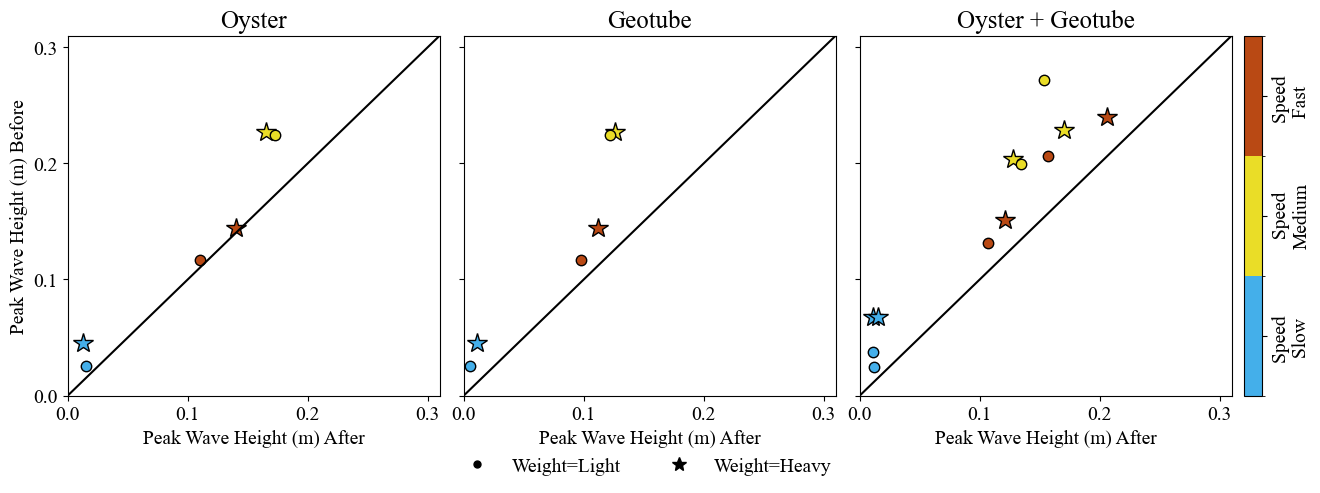

In [22]:
params = {'1':{'Heavy':'*','Light':'.','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '2':{'Heavy':'*','Light':'.','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '3':{'Heavy':'*','Light':'.','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '4':{'Heavy':'*','Light':'.','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '5':{'Heavy':'*','Light':'.','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'}}
cmap = (mpl.colors.ListedColormap(['#44AFEA', '#EADD27', '#B94914']))
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(12,4))
ax = [plt.axes([0.0,0.,0.31,0.9]),plt.axes([0.33,0.,0.31,0.9]),plt.axes([0.66,0.,0.31,0.9])]
bounds = [0,1, 2, 3]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
for f in file.index:
    if (file['Pairs'][f]==5):
        ax[1].plot(file['Peak Wave Height (m) After'][f],file['Peak Wave Height (m) Before'][f],params[str(file['Pairs'][f])][file['Weight'][f]],\
                color='k',markerfacecolor=params[str(file['Pairs'][f])][file['Speed'][f]],markersize=15,linewidth=0.05)
    elif (file['Pairs'][f]==2) or (file['Pairs'][f]==3):
        ax[2].plot(file['Peak Wave Height (m) After'][f],file['Peak Wave Height (m) Before'][f],params[str(file['Pairs'][f])][file['Weight'][f]],\
                color='k',markerfacecolor=params[str(file['Pairs'][f])][file['Speed'][f]],markersize=15,linewidth=0.05)
    elif (file['Pairs'][f]==4):
        ax[0].plot(file['Peak Wave Height (m) After'][f],file['Peak Wave Height (m) Before'][f],params[str(file['Pairs'][f])][file['Weight'][f]],\
                color='k',markerfacecolor=params[str(file['Pairs'][f])][file['Speed'][f]],markersize=15,linewidth=0.05)
for i in range(3):
    ax[i].plot([0,5],[0,5],'k')
    ax[i].set_xlim([0,0.31])
    ax[i].set_ylim([0,0.31])
    ax[i].set_xlabel('Peak Wave Height (m) After',fontsize=14)
    ax[i].set_xticks([0,0.1,0.2,0.3]),ax[i].set_yticks([0,0.1,0.2,0.3])
    ax[i].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
cbar_ax = fig.add_axes([0.98,0.,0.015,0.9])
sm =  mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm,cax = cbar_ax,orientation='vertical')
cbar.ax.set_yticks([0.5,1.5,2.5])
cbar.ax.set_yticklabels(['Speed \n Slow','  Speed\nMedium','Speed \n Fast'],fontsize = 14,rotation=90,verticalalignment='center')
myHandle = [Line2D([], [], marker='.', color='k', markersize=10, linestyle='None'),
          Line2D([], [], marker='*', color='k', markersize=10, linestyle='None')] ##Create custom handles for 2nd legend
ax[0].set_ylabel('Peak Wave Height (m) Before',fontsize=14)
ax[1].set_yticklabels(['','','','']),ax[2].set_yticklabels(['','','',''])
ax[1].set_title('Geotube',fontsize=18),ax[2].set_title('Oyster + Geotube',fontsize=18),ax[0].set_title('Oyster',fontsize=18)
ax[0].legend(handles=myHandle,labels=['Weight=Light','Weight=Heavy'],loc='lower right', bbox_to_anchor=(2.1, -0.27),ncol=2,fontsize=14,frameon=False)


plt.show()

This figure illustrates the percent decrease in peak wave height observed in trials conducted before and after the construction of NNBFs. Similar to the previous figure, the colors indicate different boat speeds, while dotted lines represent trials with heavily loaded boats and solid lines indicate trials with lightly loaded boats. The data reveal a significant difference between the effects of a single NNBF and multiple NNBFs.
- At higher speeds, oyster reefs alone resulted in only a 5% decrease in peak wave height.
- A combination of NNBFs during the same trial achieved a remarkable 30% reduction. 
- These findings highlight that the combined use of NNBFs leads to greater wave attenuation. 
- At lower speeds, the combination of Geotubes™ and oyster reefs demonstrated exceptional effectiveness in the reduction of peak wave height, with percent reductions reaching as high as 80%. 

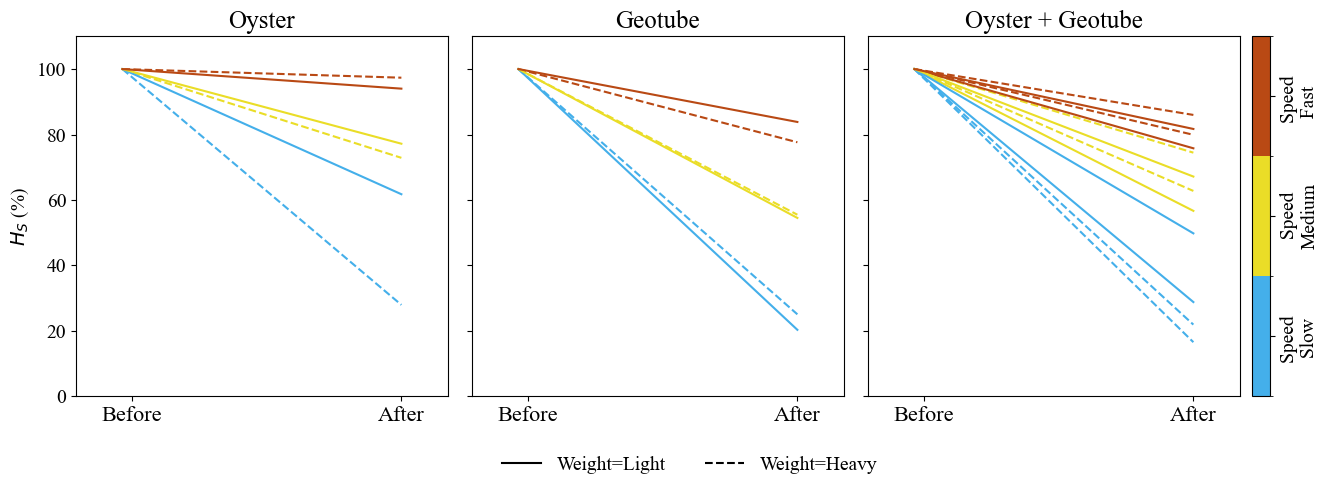

In [23]:
params = {'1':{'Heavy':'--','Light':'-','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '2':{'Heavy':'--','Light':'-','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '3':{'Heavy':'--','Light':'-','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '4':{'Heavy':'--','Light':'-','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'},
          '5':{'Heavy':'--','Light':'-','Slow':'#44AFEA','Medium':'#EADD27','Fast':'#B94914'}}
cmap = (mpl.colors.ListedColormap(['#44AFEA', '#EADD27', '#B94914']))
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(12,4))
ax = [plt.axes([0.0,0.,0.31,0.9]),plt.axes([0.33,0.,0.31,0.9]),plt.axes([0.66,0.,0.31,0.9])]
bounds = [0,1, 2, 3]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
for f in file.index:
    if (file['Pairs'][f]==5):
        hs = [100*(file['Peak Wave Height (m) Before'][f]/file['Peak Wave Height (m) Before'][f]),
              100*(file['Peak Wave Height (m) After'][f]/file['Peak Wave Height (m) Before'][f])]
        ax[1].plot([0.25,0.55],hs,
                color=params[str(file['Pairs'][f])][file['Speed'][f]],
                linestyle=params[str(file['Pairs'][f])][file['Weight'][f]],markersize=15,linewidth=1.5)
        
    elif (file['Pairs'][f]==2) or (file['Pairs'][f]==3):
        hs = [100*(file['Peak Wave Height (m) Before'][f]/file['Peak Wave Height (m) Before'][f]),
              100*(file['Peak Wave Height (m) After'][f]/file['Peak Wave Height (m) Before'][f])]
        ax[2].plot([0.25,0.55],hs,
                color=params[str(file['Pairs'][f])][file['Speed'][f]],
                linestyle=params[str(file['Pairs'][f])][file['Weight'][f]],markersize=15,linewidth=1.5)
    elif (file['Pairs'][f]==4):
        hs = [100*(file['Peak Wave Height (m) Before'][f]/file['Peak Wave Height (m) Before'][f]),
              100*(file['Peak Wave Height (m) After'][f]/file['Peak Wave Height (m) Before'][f])]
        ax[0].plot([0.25,0.55],hs,
                color=params[str(file['Pairs'][f])][file['Speed'][f]],
                linestyle=params[str(file['Pairs'][f])][file['Weight'][f]],markersize=15,linewidth=1.5)

for i in range(3):
    ax[i].set_xticks([0.26,0.55])
    ax[i].set_xlim([.2,.6])
    ax[i].set_ylim([0,110])
    ax[i].set_xticklabels(['Before','After'],fontsize=16)
    
    for label in ax[i].get_xticklabels(which='major'):
        label.set(rotation=0, horizontalalignment='center')
ax[0].tick_params(axis='y', labelsize=14)
cbar_ax = fig.add_axes([0.98,0.,0.015,0.9])
sm =  mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm,cax = cbar_ax,orientation='vertical')
cbar.ax.set_yticks([0.5,1.5,2.5])
cbar.ax.set_yticklabels(['Speed \n Slow','  Speed\nMedium','Speed \n Fast'],fontsize = 14,rotation=90,verticalalignment='center')
myHandle = [Line2D([], [], linestyle='-', color='k', markersize=10),
          Line2D([], [], linestyle='--', color='k', markersize=10)] ##Create custom handles for 2nd legend
ax[0].set_ylabel(r'$H_{S}$ (%)',fontsize=14)
ax[1].set_yticklabels(['','','','','','']),ax[2].set_yticklabels(['','','','','',''])
ax[1].set_title('Geotube',fontsize=18),ax[2].set_title('Oyster + Geotube',fontsize=18),ax[0].set_title('Oyster',fontsize=18)
ax[0].legend(handles=myHandle,labels=['Weight=Light','Weight=Heavy'],loc='lower right', bbox_to_anchor=(2.2, -0.265),ncol=2,fontsize=14,frameon=False)

plt.show()